In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
sns.set(rc={'figure.figsize':(10,5)})
os.getcwd()

'C:\\Users\\Tom Joseph\\Downloads'

In [2]:
os.chdir('C:\\Users\\Tom Joseph\\Downloads')

In [3]:
orders_table = pd.read_excel('data.xlsx',sheet_name='table_orders_new')
shift_table = pd.read_excel('data.xlsx',sheet_name='shift_table_new')
 

In [4]:
orders_table = orders_table.replace('(null)',np.nan)
shift_table = shift_table.replace('(null)',np.nan)

In [5]:
def calculate_time(a,b,c,df):
    df[c] =  pd.to_datetime(df[b]) -  pd.to_datetime(df[a]) 
    return df

In [ ]:
calculate_time('rider_picked_up_at','rider_at_customer','ride_time',orders_table)
calculate_time('rider_accepted_at','rider_dropped_off_at','delivery_time',orders_table)
calculate_time( 'rider_picked_up_at', 'expected_pickup_at','pickup_variance',orders_table)
calculate_time( 'sent_to_vendor_at','rider_accepted_at' ,'vendor_to_rider',orders_table)
calculate_time( 'rider_at_restaurant','rider_picked_up_at' ,'restaurant_wait_time',orders_table)
calculate_time( 'created_at','sent_to_vendor_at' ,'order_processing_time',orders_table)

In [7]:
print('Average delivery time :',orders_table['delivery_time'].mean())
print('Average ride time :',orders_table['ride_time'].mean())

print('Average Time taken to send order request from Vendor to Rider :',orders_table['vendor_to_rider'].mean())
print('Average delay in picking up from expected pickup :',orders_table['pickup_variance'].mean())
print('Average wait time in restaurant :',orders_table['restaurant_wait_time'].mean())
print('Average order processing time :',orders_table['order_processing_time'].mean())

Average delivery time : 0 days 00:20:42.026484
Average ride time : 0 days 00:06:19.690072
Average Time taken to send order request from Vendor to Rider : 0 days 00:02:08.563788
Average delay in picking up from expected pickup : 0 days 00:02:15.886396
Average wait time in restaurant : 0 days 00:08:24.874995
Average order processing time : 0 days 00:03:21.014120


In [8]:
 shift_table['shift_state'].value_counts(normalize=True)*100

EVALUATED          98.300537
NO_SHOW             0.983900
NO_SHOW_EXCUSED     0.715564
Name: shift_state, dtype: float64

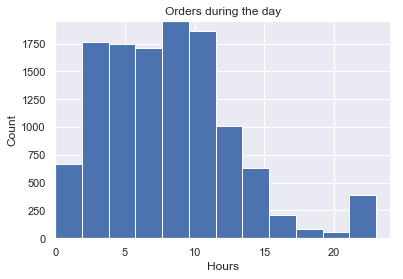

In [9]:
a = orders_table['created_at'].apply(str).apply(lambda x: x.split(' ')[1].split('.')[0]).values
# Convert to datetime format and get hours
hours_list = [dt.datetime.strptime(date, '%H:%M:%S').hour for date in a]

# Plot histogram from 0h to 24h
n, bins, patches = plt.hist(hours_list, 12)
plt.xlabel('Hours')
plt.ylabel('Count')
plt.title('Orders during the day')
plt.axis([0, 24, 0, n.max()])
plt.grid(True)

plt.show()

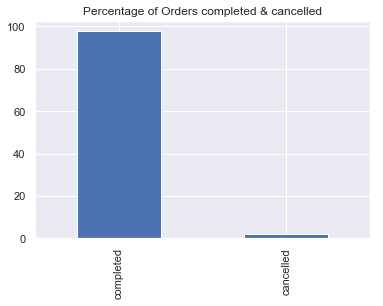

In [10]:
(orders_table['order_status'].value_counts(normalize=True)*100).plot(kind='bar')
plt.title('Percentage of Orders completed & cancelled')
plt.show()

In [ ]:
calculate_time('actual_start_at','planned_shift_start_at','start_delay',shift_table)
calculate_time('actual_start_at','actual_end_at','hours_online',shift_table)

In [12]:
print(shift_table['hours_online'].mean())

0 days 03:51:35.580003


In [13]:
shift_table['date'] = shift_table['actual_start_at'].dt.date
rider_online_df = shift_table.groupby(['rider_id','date']).agg({'hours_online':sum}).reset_index()

In [14]:
orders_table['date'] = orders_table['rider_accepted_at'].dt.date

In [15]:
ride_time_df = orders_table.groupby(['rider_id','date']).agg({'ride_time':sum,'order_id':'count'}).reset_index().rename(columns={'order_id':'#orders'})
utr = pd.merge(rider_online_df,ride_time_df,on=['date','rider_id'])
 

In [16]:
print('Time utilized effectively in (%) = ',round((utr['ride_time'].sum()/utr['hours_online'].sum())*100,2))

Time utilized effectively in (%) =  26.75


In [17]:
utr['time_utilized_in_%'] = round((utr['ride_time']/utr['hours_online'])*100,2)

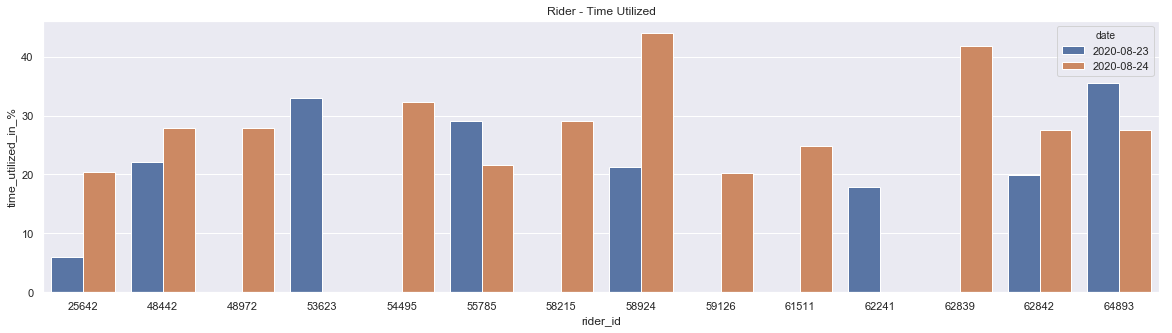

In [18]:
sns.set(rc={'figure.figsize':(20,5)})

sns.barplot(x='rider_id',y='time_utilized_in_%',hue='date',data=utr.head(20))
plt.title('Rider - Time Utilized')
plt.show()

In [19]:
print('UTR = ', round(utr['#orders'].sum()/(utr['hours_online'].sum().total_seconds()/3600),2))

UTR =  2.45


In [20]:
def calculate_utr(a,b):
    ut = round(b/(a.total_seconds()/3600),2)
    return ut

utr['daily_UTR'] = utr.apply(lambda x: calculate_utr(x['hours_online'],x['#orders']),axis=1)

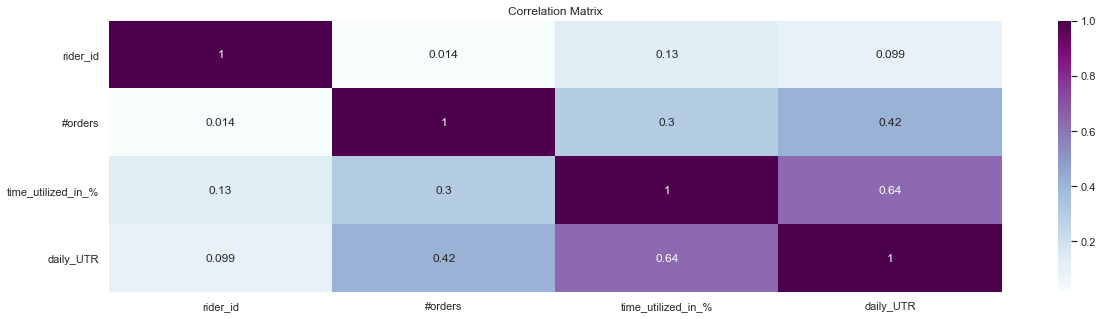

In [21]:
sns.heatmap(utr.corr(),cmap='BuPu',annot=True)
plt.title('Correlation Matrix')
plt.show()

# Insights & Recommendations 

#### From Pearson's correlation Matrix we can see that the key factor affecting UTR is the 
#### Time utilized effectively followed by number of orders 
#### How do we improve UTR ? 
    # We can see that average delivery time is approximately 21 mins, but average ride time is only 6 mins
    # It means (21-6) 15 minutes could be used more productively
    # We can find average wait time for rider at restaurant is 8 mins.This can to be reduced
    # Using Ml algorithm like Rider Optimization algorithms.
    # In this way, every rider will be assigned more orders
    # Order processing time is approximately 3 minutes.This can be reduced by aggregator through automation
    # PS: Order processing is the time taken by aggregator to sent to vendor
    # Another way is to assign more riders online during the peak hours ( 8am - 12 pm).Refer chart above.
    
    